# MNIST Denoising Autoencoder

## Reference
- http://deeplearning.net/tutorial/dA.html
- https://gist.github.com/blackecho/3a6e4d512d3aa8aa6cf9
- https://github.com/sjchoi86/tensorflow-101/blob/master/notebooks/dae_mnist.ipynb
- http://stats.stackexchange.com/questions/194426/denoising-autoencoder-not-training-properly

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
%matplotlib inline

### Data loading

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
input_dim = 784
output_dim = 784

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Data visualization

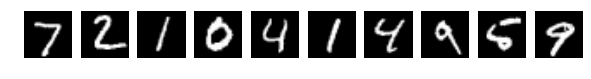

In [3]:
no_plot_img = 10
plt.rcParams['figure.figsize'] = (10, 1)
fig, ax_list = plt.subplots(1, no_plot_img)
for i in range(no_plot_img):
    image = mnist.test.images[i].reshape((28, 28))
    label = np.argmax(mnist.test.labels[i])
    ax_list[i].axis('off')
    ax_list[i].imshow(image, cmap='gray')
plt.show()

## Design

In [4]:
hidden_dim = 400

with tf.device('/gpu:0'):
    # Dropout rate
    dr = tf.placeholder(tf.float32)

    # Input and output
    X  = tf.placeholder(tf.float32, [None, input_dim])
    Y  = tf.placeholder(tf.float32, [None, output_dim])

    # Encoding
    W1 = tf.Variable(tf.random_normal([input_dim, hidden_dim]))
    b1 = tf.Variable(tf.random_normal([1]))
    H1 = tf.sigmoid(tf.add(tf.matmul(X, W1), b1))
    H1_d = tf.nn.dropout(H1, 1 - dr)

    # Decoding
    W2 = tf.Variable(tf.random_normal([hidden_dim, output_dim]))
    b2 = tf.Variable(tf.random_normal([1]))
    H2 = tf.sigmoid(tf.add(tf.matmul(H1_d, W2), b2))

    # Cost function
    cost_reconstruction = tf.sqrt(tf.reduce_mean(tf.square(tf.sub(Y, H2))))
    cost_regularization = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2)
    reg_coeff = tf.placeholder(tf.float32)
    cost = cost_reconstruction + reg_coeff * cost_regularization
    train_op = tf.train.AdamOptimizer(tf.Variable(0.005)).minimize(cost)

## Training

In [5]:
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    dropout_rate = 0.25
    regularization_coefficient = 0.000001
    num_epochs = 100
    batch_size = 256
    tf.global_variables_initializer().run(session = sess)
    
    costs = []
    for i in xrange(num_epochs):
        # Fit the model
        for j in xrange(mnist.train.num_examples / batch_size):
            batch_X, batch_Y = mnist.train.next_batch(batch_size)
            noise = 0.3 * np.random.randn(batch_size, input_dim)
            batch_X_noisy = batch_X + noise
            sess.run(train_op, feed_dict={
                    X:batch_X_noisy,
                    Y:batch_X,
                    reg_coeff:regularization_coefficient,
                    dr:dropout_rate})
        weights = sess.run(W1).T
        
        # Deal with cost
        val_feed_dict = {
            X:mnist.train.images[:1000],
            Y:mnist.train.images[:1000],
            reg_coeff:regularization_coefficient,
            dr:0.0}
        cost_val_train_1 = sess.run(cost_reconstruction, feed_dict=val_feed_dict)
        cost_val_train_2 = sess.run(cost_regularization, feed_dict=val_feed_dict)
        cost_val = cost_val_train_1 + regularization_coefficient*cost_val_train_2
        costs.append(cost_val)
        
        # Print the result and save the visualized weights
        if (i == 0) or (((i+1) % 5) == 0):
            print('%d\t%f\t%f\t%f'%(
                    i+1,
                    cost_val_train_1,
                    regularization_coefficient*cost_val_train_2,
                    cost_val))

    X_test_noisy = mnist.test.images[:100] + 0.3 * np.random.randn(100, input_dim)
    H_test_noisy = sess.run(H2, feed_dict={X:X_test_noisy, dr:0})

1	0.271046	0.187095	0.458141
5	0.097089	0.022679	0.119768
10	0.075644	0.007797	0.083442
15	0.074394	0.007165	0.081559
20	0.070793	0.007192	0.077985
25	0.072131	0.007241	0.079373
30	0.072284	0.007283	0.079566
35	0.070378	0.007310	0.077688
40	0.069381	0.007326	0.076707
45	0.069044	0.007336	0.076381
50	0.069741	0.007368	0.077110
55	0.067489	0.007399	0.074888
60	0.069214	0.007363	0.076577
65	0.070032	0.007372	0.077405
70	0.069085	0.007386	0.076471
75	0.069119	0.007403	0.076521
80	0.068432	0.007405	0.075837
85	0.068781	0.007417	0.076198
90	0.070275	0.007416	0.077691
95	0.068788	0.007416	0.076204
100	0.068666	0.007430	0.076095


## Result visualization: reconstruction

Original images / noisy images / reconstructed images


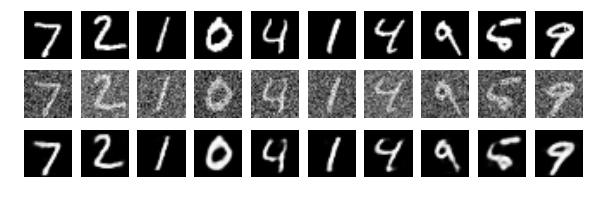

In [6]:
print('Original images / noisy images / reconstructed images')
no_plot_img = 10
plt.rcParams['figure.figsize'] = (10, 3)
fig, ax_list = plt.subplots(3, no_plot_img)
for i in range(no_plot_img):
    image = mnist.test.images[i].reshape((28, 28))
    ax_list[0][i].axis('off')
    ax_list[0][i].imshow(image, cmap='gray')
    image = X_test_noisy[i].reshape((28, 28))
    ax_list[1][i].axis('off')
    ax_list[1][i].imshow(image, cmap='gray')
    image = H_test_noisy[i].reshape((28, 28))
    ax_list[2][i].axis('off')
    ax_list[2][i].imshow(image, cmap='gray')
plt.show()

## Result visualization: weights

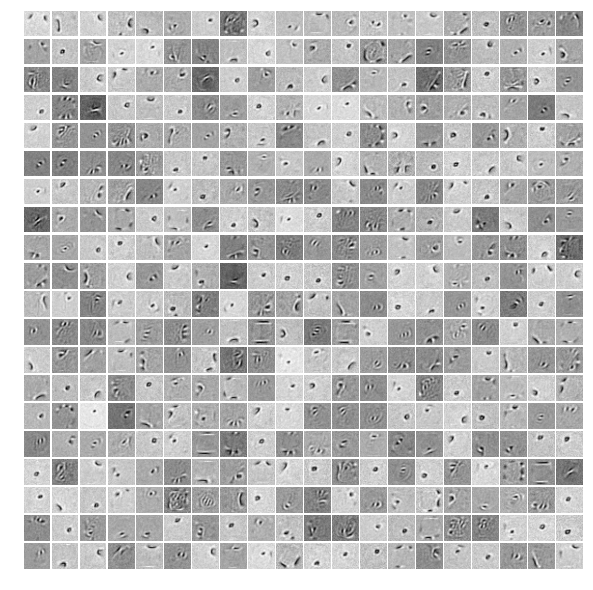

In [7]:
tile_size = int(np.sqrt(weights.shape[0]))
tile_len = int(np.sqrt(weights.shape[1]))
plt.rcParams['figure.figsize'] = (10, 10)
fig, ax_list = plt.subplots(tile_size, tile_size)
for row_i in range(tile_size):
    for col_i in range(tile_size):
        image = weights[row_i * tile_size + col_i]
        max_val = np.max(image)
        min_val = np.min(image)
        norm_image = image
        norm_image = norm_image.reshape((tile_len, tile_len))
        ax_list[row_i][col_i].axis('off')
        ax_list[row_i][col_i].imshow(norm_image, cmap='gray')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()